# Lab 4: Sequential Data

This lab is based on an assignment developed by Prof. Lisa Zhang.

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.
5. Understand how transfer learning can be applied to NLP projects.

### What to submit

Submit an HTML file containing all your code, outputs, and write-up
from parts A and B. You can produce a HTML file directly from Google Colab. The Colab instructions are provided at the end of this document.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

## Colab Link

Include a link to your colab file here

Colab Link: https://drive.google.com/file/d/1MDXzJWH-eFrjdfht019EYeSU1IbSkrlt/view?usp=sharing

# PART A - Spam Detection [30 pt]

In this part we will construct a LSTM model for identifying spam from non spam messages.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Part 1. Data Cleaning [10 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [1 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

The label value for a spam is "spam" and the label value for non-spam is "ham"

In [ ]:
for line in open('SMSSpamCollection'):
  if "ham" in line:
    print(line)
    break

for line in open('SMSSpamCollection'):
  if "spam" in line:
    print(line)
    break

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
num_1=0
for line in open('SMSSpamCollection'):
  if(line.split()[0]=="spam"):
    num_1=num_1+1
print("Spam message number: ",num_1)

num_2=0
for line in open('SMSSpamCollection'):
  if(line.split()[0]=="ham"):
    num_2=num_2+1
print("Non-spam message number: ",num_2)


Spam message number:  747
Non-spam message number:  4827


### Part (c) [2 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

**Advantages**: only alphabets and punctuations (maybe?) to inlcude so less things to include than languages and we can include a variety of languages since we are just taking the sequence of characters   <br>
**Disadvantages**: sequence of words requires less computations and in words we have less hidden layer (character based needs more hidden layers).

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

https://stackoverflow.com/questions/66516388/attributeerror-module-torchtext-data-has-no-attribute-field

In [ ]:
import torchtext
import random

text_field = torchtext.legacy.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.legacy.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.legacy.data.TabularDataset("SMSSpamCollection", # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)

# dataset[0].sms
# dataset[0].label
train, valid, test = dataset.split(split_ratio=[0.6,0.2,0.2],random_state=random.getstate())

In [ ]:
print("The number of training samples is: ",len(train))
print("The number of validation samples is: ",len(valid))
print("The number of testing samples is: ",len(test))

The number of training samples is:  3343
The number of validation samples is:  1115
The number of testing samples is:  1114


### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

Answer: <br>
Having a balanced dataset is important since our model needs to be trained on an approx. equal number of spam messages as non-spam messages. If not trained on balanced dataset the model will missclassify spam messages as non-spam.

In [ ]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [ ]:
text_field.build_vocab(train)
#text_field.vocab.stoi
#text_field.vocab.itos

text_field.vocab.stoi --> collection of characters with a numerical value assigned for each character that torchtext.data.TabularDataset has found in the sentences of the file SMSSpamCollection.

In [ ]:
text_field.vocab.stoi

defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7f96c5a403d0>>,
            {' ': 2,
             '!': 46,
             '"': 78,
             '#': 80,
             '$': 86,
             '%': 96,
             '&': 64,
             "'": 59,
             '(': 76,
             ')': 71,
             '*': 72,
             '+': 75,
             ',': 45,
             '-': 62,
             '.': 16,
             '/': 61,
             '0': 15,
             '1': 23,
             '2': 26,
             '3': 42,
             '4': 38,
             '5': 32,
             '6': 43,
             '7': 37,
             '8': 28,
             '9': 47,
             ':': 65,
             ';': 74,
             '<': 88,
             '<pad>': 1,
             '<unk>': 0,
             '=': 83,
             '>': 81,
             '?': 60,
             '@': 82,
             'A': 41,
             'B': 55,
             'C': 33,
             'D': 54,
             'E': 31,
   

text_field.vocab.itos just order the character in an ascending order based on their numerical value assigned by text_field.vocab.stoi .

In [ ]:
text_field.vocab.itos

['<unk>',
 '<pad>',
 ' ',
 'e',
 'o',
 't',
 'a',
 'n',
 'r',
 'i',
 's',
 'l',
 'u',
 'h',
 'd',
 '0',
 '.',
 'm',
 'c',
 'y',
 'w',
 'p',
 'g',
 '1',
 'f',
 'b',
 '2',
 'T',
 '8',
 'k',
 'v',
 'E',
 '5',
 'C',
 'S',
 'O',
 'I',
 '7',
 '4',
 'N',
 'x',
 'A',
 '3',
 '6',
 'R',
 ',',
 '!',
 '9',
 'M',
 'P',
 'W',
 'U',
 'L',
 'H',
 'D',
 'B',
 'G',
 'Y',
 'F',
 "'",
 '?',
 '/',
 '-',
 '£',
 '&',
 ':',
 'X',
 'z',
 'V',
 'j',
 'K',
 ')',
 '*',
 'J',
 ';',
 '+',
 '(',
 'Q',
 '"',
 'q',
 '#',
 '>',
 '@',
 '=',
 'Z',
 'ü',
 '$',
 'Ü',
 '<',
 '\x92',
 '_',
 '‘',
 '[',
 ']',
 '|',
 '\x93',
 '%',
 '…',
 'ú',
 '“',
 '–',
 '\x94',
 '\\',
 'é',
 '~',
 '^',
 '\x96',
 'É',
 'è',
 '—']

### Part (g) [1 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

**Answer:** <br>
- The tokens << unk >> --> unknown or unseen characters in our vocab <br>
- << pad >> --> means adding padding (filling with 0s to fill the missing length) before or after the character to have the length to match between words.

### Part (h) [1 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [ ]:
# add legacy
train_iter = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
train_iter.batch_size

32

Answer:

In [ ]:
i=0
for batch in train_iter:
  count1=0
  if i<=9:
    #i=i+1 
    print("The max. length of input sequence in batch ",i,":",np.array(torch.max(batch.sms[1])))
    

    for j in range(len(batch.sms[0])):
      
      # Counts the number of non-zero values in the array a
      count1=count1 + np.count_nonzero(np.array(batch.sms[0][j])==1) #index is 1
      j=j+1
    print("The number of times padding was used: ",i,"is:",count1)

  else:
    break
  i=i+1

  print()
    
    
    #print(len(batch))
    #print(batch.sms)
    #print(batch.label)

The max. length of input sequence in batch  0 : 26
The number of times padding was used:  0 is: 27

The max. length of input sequence in batch  1 : 159
The number of times padding was used:  1 is: 29

The max. length of input sequence in batch  2 : 136
The number of times padding was used:  2 is: 5

The max. length of input sequence in batch  3 : 121
The number of times padding was used:  3 is: 58

The max. length of input sequence in batch  4 : 74
The number of times padding was used:  4 is: 31

The max. length of input sequence in batch  5 : 33
The number of times padding was used:  5 is: 9

The max. length of input sequence in batch  6 : 157
The number of times padding was used:  6 is: 29

The max. length of input sequence in batch  7 : 66
The number of times padding was used:  7 is: 33

The max. length of input sequence in batch  8 : 147
The number of times padding was used:  8 is: 0

The max. length of input sequence in batch  9 : 152
The number of times padding was used:  9 is: 0

## Part 2. Model Building [5 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [ ]:
def one_hot_encoding_embedding_build(x):
  text_field.build_vocab(train)
  ident = torch.eye(len(text_field.vocab.stoi))
  for i in range(0,len(x)):
      a = ident[x[i]].unsqueeze(0)
      if i==0:
        a_new=a
      else:
        a_new=torch.cat((a_new,a),dim=0)
  return a_new

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNN, self).__init__()
        self.emb = one_hot_encoding_embedding_build
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.emb(x)
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.fc(torch.max(out, dim=1)[0])
        return out
        
model=RNN(len(text_field.vocab.stoi),50,2)

## Part 3. Training [8 pt]

### Part (a) [2 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [ ]:
val_iter=torchtext.legacy.data.BucketIterator(valid,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

In [ ]:
batch.sms[0]

tensor([[44,  3, 21,  ...,  9, 18,  3],
        [33,  6, 17,  ..., 19, 10, 16],
        [41, 18,  5,  ..., 12, 22, 13],
        ...,
        [23, 15, 15,  ..., 46,  1,  1],
        [23, 15, 15,  ..., 46,  1,  1],
        [57,  3, 10,  ..., 16,  1,  1]])

In [ ]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    cor,tot=0,0
    for batch in data: 
      length=len(batch)
      y=batch.sms[0]
      label=batch.label
      out=model(y)
      pred=out.max(1,keepdim=True)[1]
      cor=cor+pred.eq(label.view_as(pred)).sum().item()
      tot=tot+length
    return cor/tot


### Part (b) [2 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

Epoch 1; Loss 0.673134; Train Acc 0.696306; Val Acc 0.457399
Epoch 2; Loss 0.633894; Train Acc 0.556243; Val Acc 0.216143
Epoch 3; Loss 0.602282; Train Acc 0.639646; Val Acc 0.360538
Epoch 4; Loss 0.676722; Train Acc 0.890022; Val Acc 0.834081
Epoch 5; Loss 0.469870; Train Acc 0.905733; Val Acc 0.965919
Epoch 6; Loss 0.497874; Train Acc 0.937657; Val Acc 0.962332
Epoch 7; Loss 0.330915; Train Acc 0.951696; Val Acc 0.945291
Epoch 8; Loss 0.110815; Train Acc 0.952699; Val Acc 0.965022
Epoch 9; Loss 0.203925; Train Acc 0.946682; Val Acc 0.981166
Epoch 10; Loss 0.086017; Train Acc 0.954204; Val Acc 0.979372
Epoch 11; Loss 0.247401; Train Acc 0.957045; Val Acc 0.975785
Epoch 12; Loss 0.065040; Train Acc 0.959552; Val Acc 0.975785
Epoch 13; Loss 0.053968; Train Acc 0.961892; Val Acc 0.968610
Epoch 14; Loss 0.038551; Train Acc 0.958884; Val Acc 0.954260
Epoch 15; Loss 0.037679; Train Acc 0.962561; Val Acc 0.958744
Epoch 16; Loss 0.047917; Train Acc 0.967073; Val Acc 0.972197
Epoch 17; Loss 0.

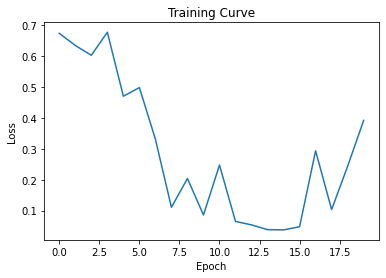

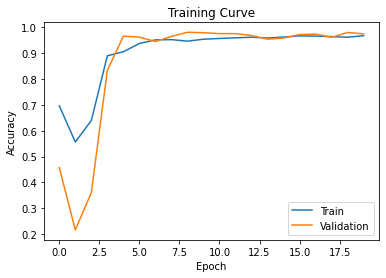

In [ ]:
import matplotlib.pyplot as plt
def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs):
        for batch in train:
            optimizer.zero_grad()
            pred = model(batch.sms[0])
            loss = criterion(pred, batch.label)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train))
        valid_acc.append(get_accuracy(model, valid))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

train_rnn_network(model, train_iter, val_iter, num_epochs=20, learning_rate=1e-4)

### Part (c) [2 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

Answer:<br>
The best performance was achieved with LSTM with 150 hidden layers which is model 5. <br>
Epoch 11; Loss 0.153028; Train Acc 0.940331; Val Acc 0.984753

1- Batch_size increase --> may increase the acc of the model  and make the training less noisy 

Epoch 1; Loss 0.768525; Train Acc 0.514792; Val Acc 0.129148
Epoch 2; Loss 0.730810; Train Acc 0.514792; Val Acc 0.129148
Epoch 3; Loss 0.729548; Train Acc 0.514959; Val Acc 0.129148
Epoch 4; Loss 0.665646; Train Acc 0.634297; Val Acc 0.480717
Epoch 5; Loss 0.580630; Train Acc 0.919606; Val Acc 0.894170
Epoch 6; Loss 0.318925; Train Acc 0.912251; Val Acc 0.864574
Epoch 7; Loss 0.310200; Train Acc 0.921277; Val Acc 0.958744
Epoch 8; Loss 0.238035; Train Acc 0.935651; Val Acc 0.949776
Epoch 9; Loss 0.339836; Train Acc 0.900050; Val Acc 0.969507
Epoch 10; Loss 0.303937; Train Acc 0.930804; Val Acc 0.965919
Epoch 11; Loss 0.129926; Train Acc 0.947184; Val Acc 0.951570
Epoch 12; Loss 0.229467; Train Acc 0.950694; Val Acc 0.945291
Epoch 13; Loss 0.250388; Train Acc 0.942838; Val Acc 0.969507
Epoch 14; Loss 0.083087; Train Acc 0.959385; Val Acc 0.938117
Epoch 15; Loss 0.101128; Train Acc 0.959051; Val Acc 0.941704
Epoch 16; Loss 0.263117; Train Acc 0.961391; Val Acc 0.944395
Epoch 17; Loss 1.

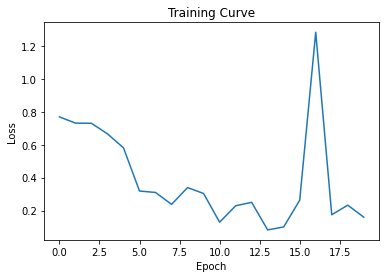

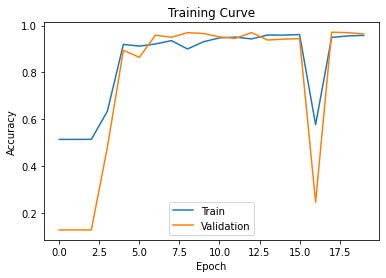

In [ ]:
train_iter2 = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=64,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)
val_iter2 = torchtext.legacy.data.BucketIterator(valid,
                                           batch_size=64,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)
model2=RNN(len(text_field.vocab.stoi),50,2)
train_rnn_network(model2, train_iter2, val_iter2, num_epochs=20, learning_rate=1e-4)

2. Change to LSTM --> solve diminishing gradient issue but more computation so it needs more time to train

Epoch 1; Loss 0.683179; Train Acc 0.841885; Val Acc 0.805381
Epoch 2; Loss 0.667676; Train Acc 0.692462; Val Acc 0.481614
Epoch 3; Loss 0.587601; Train Acc 0.553401; Val Acc 0.208072
Epoch 4; Loss 0.446334; Train Acc 0.941167; Val Acc 0.963229
Epoch 5; Loss 0.564813; Train Acc 0.907070; Val Acc 0.976682
Epoch 6; Loss 0.191623; Train Acc 0.921110; Val Acc 0.977578
Epoch 7; Loss 0.082815; Train Acc 0.919104; Val Acc 0.979372
Epoch 8; Loss 0.435011; Train Acc 0.914424; Val Acc 0.981166
Epoch 9; Loss 0.164197; Train Acc 0.914424; Val Acc 0.982063
Epoch 10; Loss 0.385784; Train Acc 0.911750; Val Acc 0.980269
Epoch 11; Loss 0.582627; Train Acc 0.906569; Val Acc 0.979372
Epoch 12; Loss 0.134320; Train Acc 0.933144; Val Acc 0.980269
Epoch 13; Loss 0.490300; Train Acc 0.924787; Val Acc 0.982063
Epoch 14; Loss 0.180009; Train Acc 0.931473; Val Acc 0.982063
Epoch 15; Loss 0.180259; Train Acc 0.951696; Val Acc 0.982063
Epoch 16; Loss 0.183093; Train Acc 0.951864; Val Acc 0.981166
Epoch 17; Loss 0.

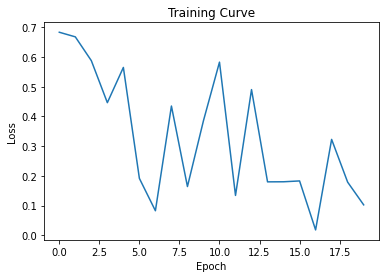

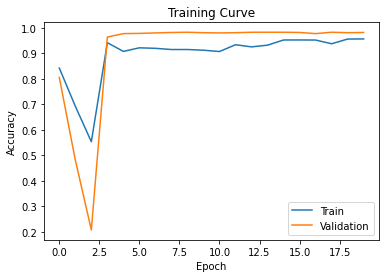

In [ ]:
class RNN2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNN2, self).__init__()
        self.emb = one_hot_encoding_embedding_build
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.emb(x)
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, (h0,c0))
        out = self.fc(torch.max(out, dim=1)[0])
        return out
model3=RNN2(len(text_field.vocab.stoi),50,2)
train_rnn_network(model3, train_iter, val_iter, num_epochs=20, learning_rate=1e-4)

3. choose GRU less computation than LSTM and might have similar performance

Epoch 1; Loss 0.658056; Train Acc 0.485208; Val Acc 0.870852
Epoch 2; Loss 0.688389; Train Acc 0.706167; Val Acc 0.920179
Epoch 3; Loss 0.659570; Train Acc 0.954036; Val Acc 0.964126
Epoch 4; Loss 0.518457; Train Acc 0.918101; Val Acc 0.897758
Epoch 5; Loss 0.311627; Train Acc 0.941501; Val Acc 0.965022
Epoch 6; Loss 0.187268; Train Acc 0.933144; Val Acc 0.979372
Epoch 7; Loss 0.582873; Train Acc 0.945178; Val Acc 0.981166
Epoch 8; Loss 0.070151; Train Acc 0.952532; Val Acc 0.979372
Epoch 9; Loss 0.068213; Train Acc 0.948855; Val Acc 0.981166
Epoch 10; Loss 0.452687; Train Acc 0.949691; Val Acc 0.978475
Epoch 11; Loss 0.044086; Train Acc 0.957546; Val Acc 0.976682
Epoch 12; Loss 0.381997; Train Acc 0.956544; Val Acc 0.976682
Epoch 13; Loss 0.372072; Train Acc 0.957546; Val Acc 0.976682
Epoch 14; Loss 0.150414; Train Acc 0.957546; Val Acc 0.975785
Epoch 15; Loss 0.128348; Train Acc 0.958549; Val Acc 0.966816
Epoch 16; Loss 0.178608; Train Acc 0.958884; Val Acc 0.974888
Epoch 17; Loss 0.

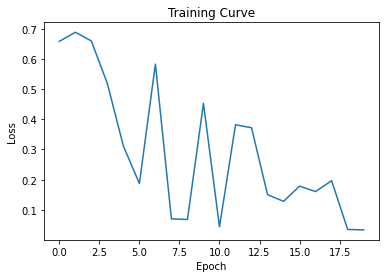

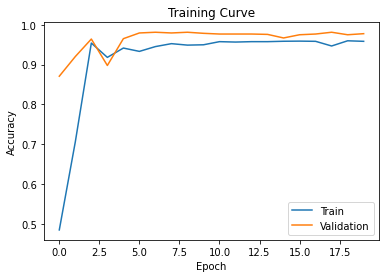

In [ ]:
class RNN3(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNN3, self).__init__()
        self.emb = one_hot_encoding_embedding_build
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.emb(x)
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.fc(torch.max(out, dim=1)[0])
        return out
model4=RNN3(len(text_field.vocab.stoi),50,2)
train_rnn_network(model4, train_iter, val_iter, num_epochs=20, learning_rate=1e-4)

4. MOre hidden layer --> may capt more features an

Epoch 1; Loss 0.622684; Train Acc 0.941167; Val Acc 0.927354
Epoch 2; Loss 0.474667; Train Acc 0.928631; Val Acc 0.965919
Epoch 3; Loss 0.208619; Train Acc 0.905231; Val Acc 0.861883
Epoch 4; Loss 0.355685; Train Acc 0.939830; Val Acc 0.982960
Epoch 5; Loss 0.072116; Train Acc 0.951864; Val Acc 0.979372
Epoch 6; Loss 0.063469; Train Acc 0.946682; Val Acc 0.981166
Epoch 7; Loss 0.113065; Train Acc 0.959051; Val Acc 0.976682
Epoch 8; Loss 0.063447; Train Acc 0.964232; Val Acc 0.973094
Epoch 9; Loss 0.196434; Train Acc 0.940164; Val Acc 0.983857
Epoch 10; Loss 0.143214; Train Acc 0.966739; Val Acc 0.971300
Epoch 11; Loss 0.277859; Train Acc 0.964733; Val Acc 0.973094
Epoch 12; Loss 0.032246; Train Acc 0.968578; Val Acc 0.971300
Epoch 13; Loss 0.170345; Train Acc 0.970249; Val Acc 0.973991
Epoch 14; Loss 0.125264; Train Acc 0.970416; Val Acc 0.976682
Epoch 15; Loss 0.025957; Train Acc 0.956376; Val Acc 0.981166
Epoch 16; Loss 0.008883; Train Acc 0.976266; Val Acc 0.979372
Epoch 17; Loss 0.

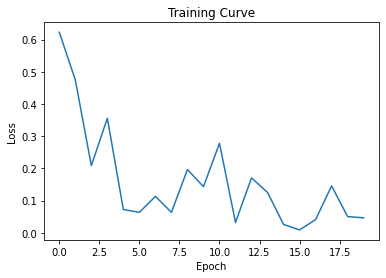

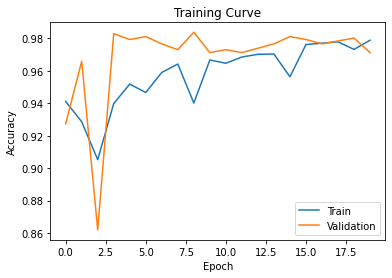

In [ ]:
model5=RNN(len(text_field.vocab.stoi),150,2)
train_rnn_network(model5, train_iter, val_iter, num_epochs=20, learning_rate=1e-4)

5. LSTM with more hidden layers 

Epoch 1; Loss 0.654338; Train Acc 0.605716; Val Acc 0.312108
Epoch 2; Loss 0.624300; Train Acc 0.924118; Val Acc 0.979372
Epoch 3; Loss 0.494056; Train Acc 0.927963; Val Acc 0.980269
Epoch 4; Loss 0.486420; Train Acc 0.919104; Val Acc 0.980269
Epoch 5; Loss 0.316416; Train Acc 0.898880; Val Acc 0.980269
Epoch 6; Loss 0.260963; Train Acc 0.911583; Val Acc 0.980269
Epoch 7; Loss 0.326362; Train Acc 0.931138; Val Acc 0.982063
Epoch 8; Loss 0.028147; Train Acc 0.923617; Val Acc 0.981166
Epoch 9; Loss 0.025540; Train Acc 0.936821; Val Acc 0.956054
Epoch 10; Loss 0.624944; Train Acc 0.930637; Val Acc 0.982063
Epoch 11; Loss 0.153028; Train Acc 0.940331; Val Acc 0.984753
Epoch 12; Loss 0.195446; Train Acc 0.949022; Val Acc 0.975785
Epoch 13; Loss 0.148280; Train Acc 0.951195; Val Acc 0.965022
Epoch 14; Loss 0.092240; Train Acc 0.948187; Val Acc 0.982063
Epoch 15; Loss 0.104934; Train Acc 0.952198; Val Acc 0.976682
Epoch 16; Loss 0.082559; Train Acc 0.950861; Val Acc 0.981166
Epoch 17; Loss 0.

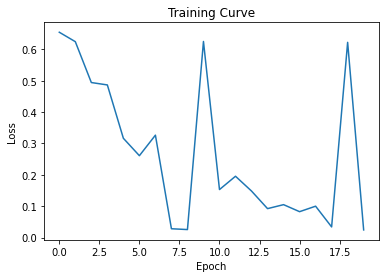

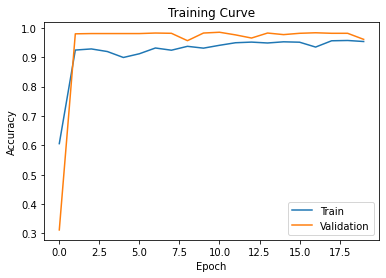

In [ ]:
class RNN2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNN2, self).__init__()
        self.emb = one_hot_encoding_embedding_build
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.emb(x)
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, (h0,c0))
        out = self.fc(torch.max(out, dim=1)[0])
        return out

model5=RNN2(len(text_field.vocab.stoi),150,2)
train_rnn_network(model5, train_iter, val_iter, num_epochs=20, learning_rate=1e-4)

### Part (d) [1 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [ ]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.legacy.data.Dataset([e for e in valid.examples if e.label == 0],valid.fields)


In [ ]:
val_spam_iter=torchtext.legacy.data.BucketIterator(valid_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), 
                                           sort_within_batch=True,        
                                           repeat=False)
                  

In [ ]:
fpr=get_accuracy(model5,val_spam_iter)
print("The false positive rate of this model is: ",1-fpr)

The false positive rate of this model is:  0.02777777777777779


In [ ]:
val_no_spam_iter=torchtext.legacy.data.BucketIterator(valid_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), 
                                           sort_within_batch=True,        
                                           repeat=False)
fnr=get_accuracy(model5,val_no_spam_iter)
print("The false negative rate of this model is: ",1-fnr)

The false negative rate of this model is:  0.04531410916580847


### Part (e) [1 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

Answer: 
- The effect of false positive rate (2.77 %) is not that significant (a non spam SMS classifed as spam). BUt it makes our algorithms inneficient since some email used for work/school/important subcription can be taken to spam folders and the person should check their spam folder in order to see it. <br> 
- The effecy of false negative rate (4.53 %) is more significant and dangerous since spam sms passes and is not detected. Considering a large organisation like UoFt receiving 100 emails per day, 3 of those email will be classified as spam incorrectly.

## Part 4. Evaluation [7 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

95.6 %

In [ ]:
test

In [ ]:
test_iter=torchtext.legacy.data.BucketIterator(test,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), 
                                           sort_within_batch=True,        
                                           repeat=False)
test_acc=get_accuracy(model5, test_iter)
print("The test accuracy of the model is:", test_acc)

The test accuracy of the model is: 0.9560143626570916


### Part (b) [1 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [ ]:
# Create a Dataset of only spam validation examples
test_spam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    test.fields)
# Create a Dataset of only non-spam validation examples
test_nospam = torchtext.legacy.data.Dataset([e for e in test.examples if e.label == 0],valid.fields)

test_spam_iter=torchtext.legacy.data.BucketIterator(test_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), 
                                           sort_within_batch=True,        
                                           repeat=False)
fpr2=get_accuracy(model5,test_spam_iter)
print("The false positive rate on the test set is:", 1-fpr2)

test_no_spam_iter=torchtext.legacy.data.BucketIterator(test_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), 
                                           sort_within_batch=True,        
                                           repeat=False)
fnr2=get_accuracy(model5,test_no_spam_iter)
print("The false negative rate on the test set is:", 1-fnr2)

The false positive rate on the test set is: 0.02777777777777779
The false negative rate on the test set is: 0.04206098843322814


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

Answer: <br> 
This is the index of each charater in the vocabulary. We are interested in M,A,C,H ... M... in the text ... 

In [ ]:
text_field.vocab.stoi

defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7f96bca85bd0>>,
            {' ': 2,
             '!': 46,
             '"': 78,
             '#': 80,
             '$': 86,
             '%': 96,
             '&': 64,
             "'": 59,
             '(': 76,
             ')': 71,
             '*': 72,
             '+': 75,
             ',': 45,
             '-': 62,
             '.': 16,
             '/': 61,
             '0': 15,
             '1': 23,
             '2': 26,
             '3': 42,
             '4': 38,
             '5': 32,
             '6': 43,
             '7': 37,
             '8': 28,
             '9': 47,
             ':': 65,
             ';': 74,
             '<': 88,
             '<pad>': 1,
             '<unk>': 0,
             '=': 83,
             '>': 81,
             '?': 60,
             '@': 82,
             'A': 41,
             'B': 55,
             'C': 33,
             'D': 54,
             'E': 31,
   

In [ ]:
import math
msg =list(tuple("machine learning is sooo cool!"))
msg2=[]
for elem in msg:
  msg2.append(text_field.vocab.stoi[elem])
#got the indices
msg2=torch.tensor(msg2).unsqueeze(0)
probabilities=model5(msg2)
sig=1/(1+math.exp(-(probabilities[0][1].item())))
print("The model's prediction of the probability of the message being spam is: ", sig)

The model's prediction of the probability of the message being spam is:  0.215004982297927


### Part (d) [2 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

Answer: <br> 
It is a difficult task because whenever new algorithms are developped hackers will try to find the flaws of the algorithm and those messages will go unnoticed. RNNs and other computationally expensive models have been developped but also simplier models have been also developed ( Adaptive Spam Filtering Technique, Previous Likeness Based Spam Filtering Technique , Heuristic or Rule Based Spam Filtering Technique and Case Base Spam Filtering Method)  that uses simpler models like SVM , KNN ect. (https://www.sciencedirect.com/science/article/pii/S2405844018353404). <br>

The way we build it will be: <br>
1. Load the dataset containing the labels and spam/ham messages.
2. Split the data into training-validation and testing.
3. Convert the text to intergers number using a method CountVectorized() that is a trivial method like one hot encoding.
4. Perform a classfication using SVm or some other simplier algorithms (other than NN) for classification.


# PART B - Transfer Learning [20 pt]

In this part we will compare our earlier model with one that takes advantage of a generative RNN model to improve the prediction. There are several ways to implement transfer learning with RNNs, here we will use an approach known as ULMFiT developed by fastai. Rather than rebuilding the model from scratch, we will take advantage of the fastai library.

Provided below is some helper code to get you started.

#### Helper Code

In [ ]:
# install relevant libraries
!pip install fastai

In [ ]:
# load relevant libraries
from fastai import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os
from fastai.text import *

In [ ]:
# download SPAM data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
!unzip smsspamcollection.zip

--2022-03-24 22:43:58--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203415 (199K) [application/x-httpd-php]
Saving to: ‘smsspamcollection.zip.1’

smsspamcollection.z 100%[===================>] 198.65K   332KB/s    in 0.6s    

2022-03-24 22:43:59 (332 KB/s) - ‘smsspamcollection.zip.1’ saved [203415/203415]

Archive:  smsspamcollection.zip
replace SMSSpamCollection? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

This time we will load the data using pandas.

In [ ]:
# set up data and verify
df1 = pd.read_csv('SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])
df1.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# check distribution
df1['target'].value_counts()

ham     4825
spam     747
Name: target, dtype: int64

Split the data into training and validation datasets.

In [ ]:
# split the data and check dimensions

#from sklearn.model_selection import train_test_split

# split data into training and validation set
#df_trn, df_val = train_test_split(df1, stratify = df1['target'], test_size = 0.3, random_state = 999)

In [ ]:
#df_trn.shape, df_val.shape

In [ ]:
train, valid, test = dataset.split(split_ratio=[0.6,0.2,0.2],random_state=random.getstate())

In [ ]:
def convert_to_pd(data):
  arr_targets=np.zeros(len(data))
  arr_texts=np.empty([len(data)],dtype="<U100")

  for i in range(0,len(data)):
    arr_targets[i]=vars(data[i]).get('label')
    arr_texts[i]=vars(data[i]).get('sms')
    df=pd.DataFrame({'target': arr_targets, 'text': arr_texts})
  return df

df_train=convert_to_pd(train)
df_val=convert_to_pd(valid)
df_test=convert_to_pd(test)

In [ ]:
df_train

,target,text
0,0.0,Or maybe my fat fingers just press all these b...
1,0.0,O shore are you takin the bus
2,0.0,Ok can...
3,0.0,U coming 2 pick me?
4,1.0,Please call our customer service representativ...
...,...,...
3338,0.0,No did you check? I got his detailed message now
3339,0.0,Oooh I got plenty of those!
3340,0.0,Den wat will e schedule b lk on sun?
3341,0.0,"Sorry man my account's dry or I would, if you ..."


In [ ]:
df_test

,target,text
0,0.0,Just seeing your missed call my dear brother. ...
1,0.0,What to think no one saying clearly. Ok leave ...
2,0.0,Think I could stop by in like an hour or so? M...
3,0.0,I thank you so much for all you do with selfle...
4,0.0,Hi:)cts employee how are you?
...,...,...
1109,0.0,Jesus armand really is trying to tell everybod...
1110,0.0,"If i let you do this, i want you in the house ..."
1111,0.0,Yes. I come to nyc for audiitions and am tryin...
1112,0.0,Tell me they're female :V how're you throwing ...


In [ ]:
df_val

,target,text
0,0.0,"Short But Cute: ""Be a good person, but dont tr..."
1,0.0,What u mean u almost done? Done wif sleeping? ...
2,1.0,Hard LIVE 121 chat just 60p/min. Choose your g...
3,0.0,"Mum, hope you are having a great day. Hoping t..."
4,0.0,"K, I might come by tonight then if my class le..."
...,...,...
1110,0.0,And smile for me right now as you go and the w...
1111,0.0,Hi Petey!noim ok just wanted 2 chat coz avent...
1112,0.0,No i'm not gonna be able to. || too late notic...
1113,0.0,Depends on where u going lor.


### Create the language model
Esentially, the language model contains the structure of the language (English in this case), allowing us to quickly use in a classification model, skipping the part of learning the semantics of the language from scratch.

Creating a language model from scratch can be intensive due to the sheer size of data. Instead we will download the pre-trained model, which is a neural network (NN) with an AWD_LSTM architecture. By setting pretrained = True we say to fastai to download the weights from the trained model (a corpus of 103 MM of wikipedia articles).

In [ ]:
# create pretrained language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")
lang_mod = language_model_learner(data_lm,  arch = AWD_LSTM, pretrained = True, drop_mult=1.)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


### Testing the language model


In [ ]:
for i in range(5):
  print(lang_mod.predict("The problem usually starts when", n_words=10))

The problem usually starts when one and Tech 's Executive Order meets
The problem usually starts when the second entry ( with the better of the two
The problem usually starts when a special player comes out on a Halloween or
The problem usually starts when Alex text out Mark 's message into a
The problem usually starts when the main part of the show is empty down .


In [ ]:
for i in range(5):
  print(lang_mod.predict("I love Cedric's cookies", n_words=10))

I love Cedric's cookies = a Queen 's Wedding Song ,
I love Cedric's cookies ( Big Brother and the Two
I love Cedric's cookies = for Christmas i ' m the Queen
I love Cedric's cookies = " Her Great Partner " is
I love Cedric's cookies ( English village football charity ) . It


In [ ]:
for i in range(5):
  print(lang_mod.predict("I love Sahil because", n_words=10))

I love Sahil because of the romantic word " Love " , meaning
I love Sahil because of my sex , look as though my character only
I love Sahil because of the name it 
  Whatever the words '
I love Sahil because it 's the same play with Margaret King
I love Sahil because he felt it has been hanging at the same time


In [ ]:
for i in range(10):
  print(lang_mod.predict("I love where ", n_words=10))

I love where  , to my mind , 's is " .
I love where  it comes from there . It shows how everything
I love where  you are getting on their way back home your moment
I love where  i Love You " first lk project .
I love where  you are , now come . Everyone is all
I love where  you are small , a girl and not yet girl
I love where  you go double thing , and stuff that it 's
I love where  you 're going ? " It 's a beautiful
I love where  you 're loving you ! " Howard Tyler
I love where  you love it and is God on the night


In [ ]:
for i in range(5):
  print(lang_mod.predict("I love ", n_words=10))

I love  game playing that is a single game in the game
I love  a person now closer to my love or the love
I love  arrested [ or ] porn person ... ) = 
 
I love  love , you 're radio station , play and play
I love  nobody else makes a movie like me . For


Each time we excecute the `predict`, we get a different random sentence, completed with the number of choosen words (`n_words`).

Try your own sentences!

### Fine-tuning the language model
The language model that we have "loaded" is great for generating wikipedia-like sentances, but here we're more interested in generating data like our email dataset. 

Make sure to enable GPU for this step or it make takes several hours to train.

In [ ]:
# fine-tune language model data
lang_mod.fit_one_cycle(4, max_lr= 5e-02)
lang_mod.freeze_to(-1)
lang_mod.fit_one_cycle(3, slice(1e-2/(2.6**4), 1e-2))
lang_mod.freeze_to(-2)
lang_mod.fit_one_cycle(3, slice(3e-3/(2.6**4), 1e-3))
lang_mod.unfreeze()
lang_mod.fit_one_cycle(3, slice(3e-3/(2.6**4), 1e-3))

# save language model
lang_mod.save_encoder('my_awsome_encoder')

epoch,train_loss,valid_loss,accuracy,time
0,5.558487,4.513807,0.242857,00:01
1,4.837755,4.006336,0.257143,00:01
2,4.377849,3.604092,0.285714,00:01
3,4.051709,3.477303,0.328571,00:01


epoch,train_loss,valid_loss,accuracy,time
0,3.570620,3.483553,0.314286,00:01
1,3.543751,3.416126,0.357143,00:01
2,3.485082,3.396751,0.357143,00:01


epoch,train_loss,valid_loss,accuracy,time
0,3.393373,3.370147,0.385714,00:01
1,3.370044,3.337121,0.385714,00:01
2,3.359846,3.340834,0.371429,00:01


epoch,train_loss,valid_loss,accuracy,time
0,3.324160,3.326411,0.385714,00:01
1,3.293988,3.270702,0.400000,00:01
2,3.268299,3.276076,0.414286,00:01


In [ ]:
def change_classes(df):
  df.loc[(df['target']==0.0),'target']="ham"
  df.loc[(df['target']==1.0),'target']="spam"
  return df

df_train=change_classes(df_train)
df_val=change_classes(df_val)
df_test=change_classes(df_test)

### Classification model
Now we can train a classification model that will identify spam and non-spam messages. Since we used a fastai language model, it will be easier to just continue working with the fastai library.

In [ ]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn,  valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
data_clas.show_batch()

/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


text,target
"xxbos xxmaj the last thing i ever wanted to do was hurt you . xxmaj and i did n't think it would have . xxmaj you 'd laugh , be embarassed , delete the xxunk and keep going . xxmaj but as far as i knew , it was n't even up . xxmaj the fact that you even felt like i would do it to hurt you shows you",ham
"xxbos a xxmaj boy loved a gal . xxmaj he xxunk bt she did nt mind . xxmaj he xxunk xxunk xxunk , xxmaj bt her frnds xxunk xxunk . xxmaj again d boy decided 2 xxunk d gal , xxunk time a xxunk was xxunk towards d gal . xxmaj xxunk it was about 2 hit d girl , d boy ran like hell n saved her . xxmaj",ham
"xxbos xxmaj solve d xxmaj case : a xxmaj man xxmaj was xxmaj found xxmaj murdered xxmaj on < xxup decimal > . < # > afternoon . 1,his wife called xxmaj police . 2,police questioned everyone . 3,wife : xxmaj sir , i was sleeping , when the murder took place . 4.cook : i was cooking . 5.gardener : i was picking vegetables . 6.house - xxmaj maid",ham
"xxbos xxmaj storming msg : xxmaj wen u lift d phne , u say "" xxup hello "" xxmaj do u knw wt is d real meaning of xxup hello ? ? . . . xxmaj it 's d name of a girl .. ! . . . xxmaj yes .. xxmaj and u knw who is dat girl ? ? "" xxmaj margaret xxmaj hello "" xxmaj she is",ham
"xxbos xxmaj you are everywhere xxunk , on the floor , the windows , even on my shirt . xxmaj and sometimes when i open my xxunk , you are all that comes xxunk out . i dream of my world without you , then half my xxunk are out too . a time of joy for me , lots of tv shows i.ll see . xxmaj but i guess",ham


In [ ]:
# create the classifier
learn_classifier = text_classifier_learner(data_clas, drop_mult=0.7, arch = AWD_LSTM)

In [ ]:
# load language model
learn_classifier.load_encoder('my_awsome_encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (3900 items)
x: TextList
xxbos i liked your new house,xxbos xxmaj xxunk i 'm walking in xxunk now ü faster come down ... xxmaj me very hungry ...,xxbos xxmaj wan2 win a meet+greet with xxmaj westlife 4 u or a m8 ? xxmaj they are currently on what tour ? 1)unbreakable , 2)untamed , 3)unkempt . xxmaj text 1,2 or 3 to 83049 . xxmaj cost 50p + std text,xxbos xxmaj otherwise had part time job na - tuition ..,xxbos xxmaj wait , do you know if xxunk in town ? i bet she does hella drugs !
y: CategoryList
ham,ham,spam,ham,ham
Path: .;

Valid: LabelList (1115 items)
x: TextList
xxbos xxmaj short xxmaj but xxmaj cute : " xxmaj be a good person , but do nt try to prove it .. " xxunk noon xxrep 4 .,xxbos xxmaj what u mean u almost done ? xxmaj done wif sleeping ? xxmaj but i tot u going to take a nap .. xxmaj yup i send her liao,xxbos xxmaj hard xxup live 121 chat just 60p / min . xxmaj choose your girl and connect xxup live . xxmaj call xxunk no

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-03
Min loss divided by 10: 2.51E-02


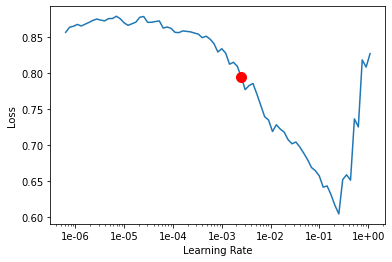

In [ ]:
# train classifier
learn_classifier.lr_find()
learn_classifier.recorder.plot(suggestion=True)

In [ ]:
learn_classifier.fit_one_cycle(5, max_lr=1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.442391,0.091202,0.975785,00:02
1,0.178967,0.084104,0.973991,00:02
2,0.113877,0.078113,0.974888,00:02
3,0.100559,0.083886,0.981166,00:02
4,0.101038,0.093054,0.973094,00:02


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must

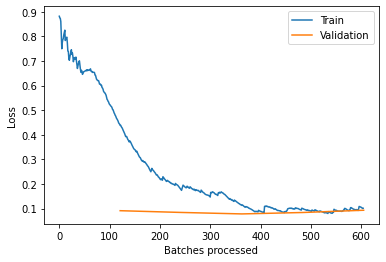

In [ ]:
learn_classifier.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.29E-07


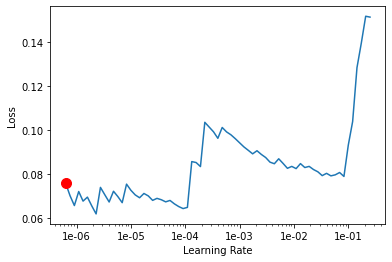

In [ ]:
lang_mod.freeze_to(-1)

learn_classifier.lr_find()
learn_classifier.recorder.plot(suggestion=True)

Test out the classification model on spam and non-spam examples.

In [ ]:
# predict
learn_classifier.predict('did you buy the groceries for dinner? :)')

(Category tensor(0), tensor(0), tensor([9.9998e-01, 2.2651e-05]))

In [ ]:
# predict
learn_classifier.predict('Free entry call back now')

(Category tensor(1), tensor(1), tensor([0.4017, 0.5983]))

Next we will evaluate on all of our validation data.

In [ ]:
# get predictions from validation
valid_preds, valid_label=learn_classifier.get_preds(ds_type=DatasetType.Valid, ordered=True)
valid_preds.shape

torch.Size([1115, 2])

## Part 1. Evaluate Performance [10pt]

### Part (a) [5pt]

Implement the above helper code for spam detection. 

What is the accuracy obtained with ULMFiT? How does ULMFiT compare to the approach in the first part using only LSTM?

Answer: <br>
The accuracy is 0.981166 which is better than the one obtained for LSTM 	

### Part (b) [5pt]
Provide a confusion matrix of the performance for the two models. How do they compare? Are there any qualitative differences between the performances (i.e. examine the samples for which the models differred)?

Answer:<br>
The ULMFit is doing way more better and one could see it by just looking at the accuracies. Our ULMFit model has 97.3 % accuracy which is very good when compared to the perdormance of model5 which is LSTM with 150 hiden layers. Evaluating the model using FPR, FNR ULMFit is performing better both ways. Doing the comparision: <br>
Acc (ULMFit) = 97.3%   <br>
TPR (ULMFit) =  97 % <br>
TNR (ULMFit) = 100 %  <br> 
FNR (ULMFit) = 2.997 %  <br>
FPR (ULMFit) = 0 %  <br>
<br> 
Acc (LSTM) =  43.4 %  <br>
TPR (LSTM) =  91.26 % <br>
TNR (LSTM) = 15.362 %  <br> 
FNR (LSTM) =  8.7 %   <br>
FPR (LSTM) =  84.63 % <br>

**Confusion Matrix for ULMFiT model:**

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
valid_preds

tensor([[9.9939e-01, 6.0615e-04],
        [9.9643e-01, 3.5682e-03],
        [1.7099e-02, 9.8290e-01],
        ...,
        [9.9986e-01, 1.4295e-04],
        [9.9964e-01, 3.5574e-04],
        [1.8479e-01, 8.1521e-01]])

In [ ]:
pred_label=torch.max(valid_preds,1)[1]
cm1=confusion_matrix(list(valid_label),list(pred_label))
cm1

array([[971,   0],
       [ 30, 114]])

In [ ]:
# 0.0299 false negative rate

**Confusion Matrix for LSTM model from last part:**

In [ ]:

k=0

val_iter=torchtext.legacy.data.BucketIterator(valid,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)
for i in val_iter:
  if k==0:
    valid_label_A=i.label
  else:
    valid_label_A=torch.cat((valid_label_A,i.label),0)
  k+=1


def get_cm(model, data):
    k=0
    for batch in data:
      y=batch.sms[0]
      label=batch.label
      output = model(y)
      pred = output.max(1, keepdim=True)[1]
      if k==0:
        valid_pred_A=pred.reshape(1,-1)[0]
      else:
        valid_pred_A=torch.cat((valid_pred_A,pred.reshape(1,-1)[0]),0)
      k+=1
    return valid_pred_A

valid_pred_A=get_cm(model5,val_iter)

In [ ]:
cm2=confusion_matrix(list(valid_label_A),list(valid_pred_A))
cm2

array([[376, 595],
       [ 36, 108]])

The accuracy is very low. 

## Part 2. Evaluate on New Data [10pt]

### Part (a) [4pt]
What is your model's prediction of the probability that the SMS message "machine learning is sooo cool!" is spam?

In [ ]:
s=learn_classifier.predict('machine learning is sooo cool!')
print("The model's prediction of the probability that the message is spam is:", s[2][1].item())

The model's prediction of the probability that the message is spam is: 5.414066422691198e-20


### Part (b) [3 pt] 
Load 5 sample sentences from your spam mail and test it out out the two models you created. How well do they perform?

ULMFit performs better than LSTM.

In [ ]:
msg_spam_list=['Dear XXXX, Our security system has detected some irregular activity connected to your account.', 'URGENT, PLEASE HELP! I am stranded on a desert island, send 100000$!!!!', 'BRAND NEW APP ON THIS LINK, only pay 3$!', 'ITS YOUR CHANCE to win 5666$ in bitcoin', 'LIMITED TIME OFFER call to be the first!!']

In [ ]:
#ULMFiT
spam_number=0
for i in msg_spam_list:
  pred=learn_classifier.predict(i)
  if pred[1]==1:
    spam_number= spam_number+1
    
spam_number=spam_number/5
print("The accuracy of detecting spam emails is:", spam_number)

The accuracy of detecting spam emails is: 0.8


In [ ]:
#LSTM only 
spam_number2=0
for j in msg_spam_list:
  j_new=list(tuple(i))
  j_new2=[]
  for i in enumerate(j_new):
    j_new2.append(text_field.vocab.stoi[i[1]])

  j_new2=torch.tensor(j_new2).unsqueeze(0)
  prob=model5(j_new2)
  pred=prob.max(1,keepdim=True)[1]
  if pred.item()==1:
    spam_number2+=1
spam_number2=spam_number2/5
print("The accuracy of detecting spam emails is:", spam_number2)

The accuracy of detecting spam emails is: 0.0


### Part (c) [3pt]
Load 5 sample sentences from your regular mail and test it out out the two models you created. How well do they perform?

Answer: <br> 
LSTM model 5 with 150 hidden layers performs better  in this case. 

In [ ]:
msg_ham_list=['Provided below are some details related to the final assessment of MIE1626.','Please find below details for a virtual seminar co-hosted by the University of Pittsburgh, UPMC, Carnegie Mellon University and UofT','Please note that the UTGSU Office will be closed on March 23rd.','Hello Ali, Thank you for your email','I uploaded my slides as well']

In [ ]:
#ULMFiT
ham_number=0
for i in msg_ham_list:
  pred=learn_classifier.predict(i)
  if pred[1]==0:
    ham_number= ham_number+1
    
ham_number=ham_number/5
print("The accuracy of detecting ham emails is:", ham_number)

The accuracy of detecting ham emails is: 0.8


In [ ]:
# LSTM 
ham_number2=0
for j in msg_ham_list:
  j_new=list(tuple(i))
  j_new2=[]
  for i in enumerate(j_new):
    j_new2.append(text_field.vocab.stoi[i[1]])

  j_new2=torch.tensor(j_new2).unsqueeze(0)
  prob=model(j_new2)
  pred=prob.max(1,keepdim=True)[1]
  if pred.item()==0:
    ham_number2=ham_number2+1
ham_number2=ham_number2/5
print("The accuracy of detecting ham emails is:", ham_number2)

The accuracy of detecting ham emails is: 1.0


### Saving to HTML
Detailed instructions for saving to HTML can be found <a href="https://stackoverflow.com/questions/53460051/convert-ipynb-notebook-to-html-in-google-colab/64487858#64487858">here</a>. Provided below are a summary of the instructions:

(1) download your ipynb file by clicking on File->Download.ipynb

(2) reupload your file to the temporary Google Colab storage (you can access the temporary storage from the tab to the left)

(3) run the following:

In [ ]:
%%shell
jupyter nbconvert --to html LAB_4_Sequential_Data..ipynb

[NbConvertApp] Converting notebook LAB_4_Sequential_Data..ipynb to html
[NbConvertApp] Writing 815232 bytes to LAB_4_Sequential_Data..html


(4) the html file will be available for download in the temporary Google Colab storage

(5) review the html file and make sure all the results are visible before submitting your assignment to Quercus